In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import xgboost as xgb 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime

1. Load the csv file in.

In [2]:
aqiDF = pd.read_csv('aqi_ny.csv')

In [3]:
aqiDF

,Unnamed: 0,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


2. Drop the extra index.

In [4]:
aqiDF = aqiDF.drop('Unnamed: 0', axis=1)

In [5]:
aqiDF

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


3. We are trying to predict values mainly on time, so we want to get rid of all the columns other than date and what we are trying to predict, AQI. 

In [6]:
df = aqiDF[['date', 'aqi']]

In [7]:
df

,date,aqi
0,2020-12-01 05:00:00,2
1,2020-12-01 06:00:00,1
2,2020-12-01 07:00:00,1
3,2020-12-01 08:00:00,1
4,2020-12-01 09:00:00,1
...,...,...
18056,2022-12-31 13:00:00,3
18057,2022-12-31 14:00:00,3
18058,2022-12-31 15:00:00,4
18059,2022-12-31 16:00:00,3


4. Make the date column the index, and change its datatype to datetime.

In [8]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [9]:
df

,aqi
date,
2020-12-01 05:00:00,2
2020-12-01 06:00:00,1
2020-12-01 07:00:00,1
2020-12-01 08:00:00,1
2020-12-01 09:00:00,1
...,...
2022-12-31 13:00:00,3
2022-12-31 14:00:00,3
2022-12-31 15:00:00,4


5. Split the data into training and testing data, roughly a 75/25 split. In this case, we did it based on date instead of train test split because we wanted to make sure the data stayed consecutive. 

In [10]:
train = df.loc[df.index < '2022-07-01']
test = df.loc[df.index >= '2022-07-01']

6. Visualize the training versus testing data.

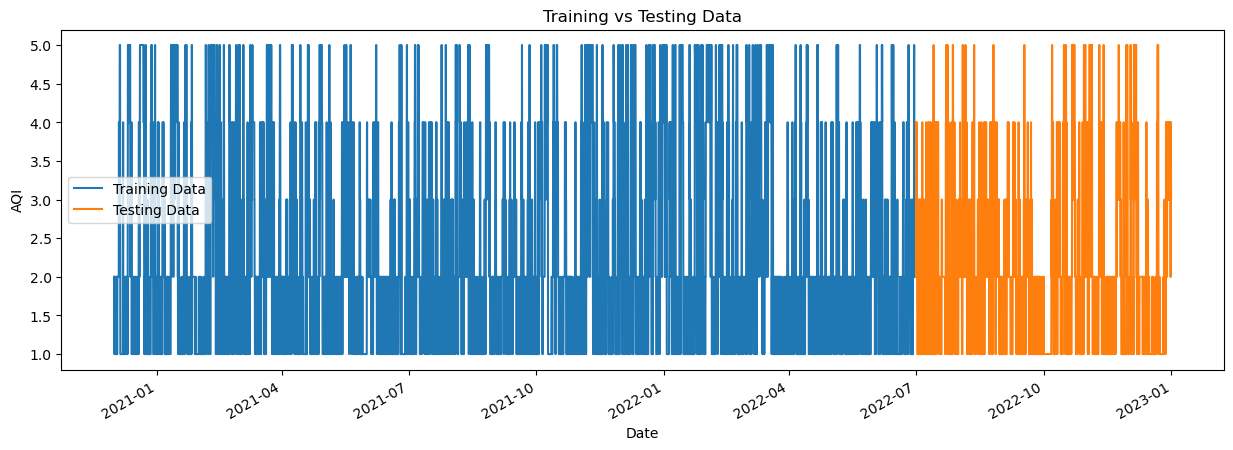

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label='Test Set')
plt.title('Training vs Testing Data')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend(['Training Data','Testing Data'])
plt.show()

In [12]:
train 

,aqi
date,
2020-12-01 05:00:00,2
2020-12-01 06:00:00,1
2020-12-01 07:00:00,1
2020-12-01 08:00:00,1
2020-12-01 09:00:00,1
...,...
2022-06-30 19:00:00,3
2022-06-30 20:00:00,3
2022-06-30 21:00:00,4


In [13]:
test

,aqi
date,
2022-07-01 00:00:00,4
2022-07-01 01:00:00,4
2022-07-01 02:00:00,4
2022-07-01 03:00:00,4
2022-07-01 04:00:00,4
...,...
2022-12-31 13:00:00,3
2022-12-31 14:00:00,3
2022-12-31 15:00:00,4


7. Machine Learning Models are not typically used on time series data, but XGBoost is considered one of the best models to use if you want to use a ML model to predict time series data. The model does not understand time, so you have to add features so that it gets a sense of how the data changes over time. To do this, we added extra feature columns that say what hour of the day, day of the week, and week of the year, etc, the row of data comes from. 

In [14]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df


df = create_features(df)
test = create_features(test)
train = create_features(train)

8. We also added three columns of lag features, which show the values for the last three hours for each row. 

In [15]:
def add_lags(df):
    target_map = df['aqi'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 hour')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 hours')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 hours')).map(target_map)
    return df

In [16]:
df = add_lags(df)
test = add_lags(test)
train = add_lags(train)

In [17]:
train 

,aqi,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
date,,,,,,,,,,
2020-12-01 05:00:00,2,5,1,4,12,2020,336,NaN,NaN,NaN
2020-12-01 06:00:00,1,6,1,4,12,2020,336,2.0,NaN,NaN
2020-12-01 07:00:00,1,7,1,4,12,2020,336,1.0,2.0,NaN
2020-12-01 08:00:00,1,8,1,4,12,2020,336,1.0,1.0,2.0
2020-12-01 09:00:00,1,9,1,4,12,2020,336,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,3,19,3,2,6,2022,181,3.0,3.0,3.0
2022-06-30 20:00:00,3,20,3,2,6,2022,181,3.0,3.0,3.0
2022-06-30 21:00:00,4,21,3,2,6,2022,181,3.0,3.0,3.0


In [18]:
df

,aqi,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
date,,,,,,,,,,
2020-12-01 05:00:00,2,5,1,4,12,2020,336,NaN,NaN,NaN
2020-12-01 06:00:00,1,6,1,4,12,2020,336,2.0,NaN,NaN
2020-12-01 07:00:00,1,7,1,4,12,2020,336,1.0,2.0,NaN
2020-12-01 08:00:00,1,8,1,4,12,2020,336,1.0,1.0,2.0
2020-12-01 09:00:00,1,9,1,4,12,2020,336,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 13:00:00,3,13,5,4,12,2022,365,2.0,2.0,2.0
2022-12-31 14:00:00,3,14,5,4,12,2022,365,3.0,2.0,2.0
2022-12-31 15:00:00,4,15,5,4,12,2022,365,3.0,3.0,2.0


In [19]:
test

,aqi,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
date,,,,,,,,,,
2022-07-01 00:00:00,4,0,4,3,7,2022,182,NaN,NaN,NaN
2022-07-01 01:00:00,4,1,4,3,7,2022,182,4.0,NaN,NaN
2022-07-01 02:00:00,4,2,4,3,7,2022,182,4.0,4.0,NaN
2022-07-01 03:00:00,4,3,4,3,7,2022,182,4.0,4.0,4.0
2022-07-01 04:00:00,4,4,4,3,7,2022,182,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 13:00:00,3,13,5,4,12,2022,365,2.0,2.0,2.0
2022-12-31 14:00:00,3,14,5,4,12,2022,365,3.0,2.0,2.0
2022-12-31 15:00:00,4,15,5,4,12,2022,365,3.0,3.0,2.0


9. Separate what you are trying to predict from your predictors, and do that for both the training and testing sets. 

In [20]:
features = ['hour','dayofweek','quarter','month','year','dayofyear', 'lag1', 'lag2', 'lag3']
target = 'aqi'

In [21]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

10. Create the model, which includes instantiating and fitting the model. The number of trees is high so the learning rate has to be low, the lower the learning rate the longer it will take to run. The model will also stop running early on if it is not improving. 

In [22]:
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                       learning_rate=.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:2.07345	validation_1-rmse:1.91926
[1]	validation_0-rmse:2.07147	validation_1-rmse:1.91744
[2]	validation_0-rmse:2.06950	validation_1-rmse:1.91562
[3]	validation_0-rmse:2.06754	validation_1-rmse:1.91380
[4]	validation_0-rmse:2.06557	validation_1-rmse:1.91199
[5]	validation_0-rmse:2.06361	validation_1-rmse:1.91017
[6]	validation_0-rmse:2.06165	validation_1-rmse:1.90836
[7]	validation_0-rmse:2.05969	validation_1-rmse:1.90655
[8]	validation_0-rmse:2.05773	validation_1-rmse:1.90474
[9]	validation_0-rmse:2.05577	validation_1-rmse:1.90294
[10]	validation_0-rmse:2.05382	validation_1-rmse:1.90113
[11]	validation_0-rmse:2.05187	validation_1-rmse:1.89933
[12]	validation_0-rmse:2.04992	validation_1-rmse:1.89752
[13]	validation_0-rmse:2.04797	validation_1-rmse:1.89572
[14]	validation_0-rmse:2.04603	validation_1-rmse:1.89392
[15]	validation_0-rmse:2.04408	validation_1-rmse:1.89213
[16]	validation_0-rmse:2.04214	validation_1-rmse:1.89033
[17]	validation_0-rmse:2.04020	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

11. Create a dataframe that measures how important each feature is for the model's calculations. 

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index= reg.feature_names_in_,
                  columns=['importance'])

In [24]:
fi

,importance
hour,0.001601
dayofweek,0.000514
quarter,0.000205
month,0.000766
year,0.000555
dayofyear,0.000745
lag1,0.987813
lag2,0.005554
lag3,0.002248


12. Create a graph to visualize feature importance, as you can see 'lag 1' is the most important feature by far. This means that when it comes to the extra features, the model is mostly basing its predictions on the data from the last hour. 

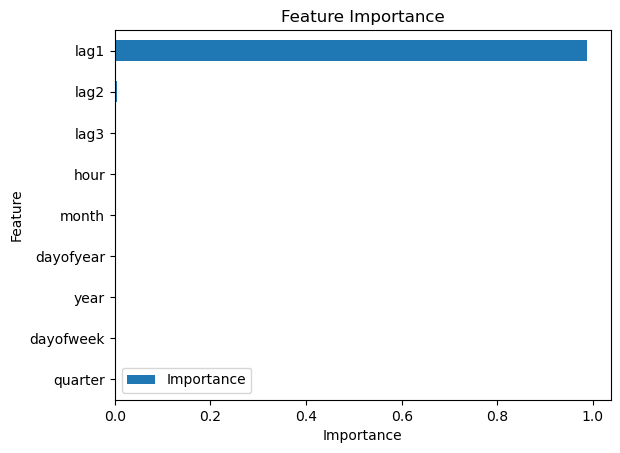

In [25]:
fi.sort_values('importance').plot(kind='barh')
plt.title('Feature Importance')
plt.legend(['Importance'])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

13. Calculate the predicted values and create a column for the values in the main dataframe. 

In [26]:
test['prediction'] = reg.predict(X_test)

In [27]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [28]:
df

,aqi,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,prediction
date,,,,,,,,,,,
2020-12-01 05:00:00,2,5,1,4,12,2020,336,NaN,NaN,NaN,NaN
2020-12-01 06:00:00,1,6,1,4,12,2020,336,2.0,NaN,NaN,NaN
2020-12-01 07:00:00,1,7,1,4,12,2020,336,1.0,2.0,NaN,NaN
2020-12-01 08:00:00,1,8,1,4,12,2020,336,1.0,1.0,2.0,NaN
2020-12-01 09:00:00,1,9,1,4,12,2020,336,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 13:00:00,3,13,5,4,12,2022,365,2.0,2.0,2.0,2.045726
2022-12-31 14:00:00,3,14,5,4,12,2022,365,3.0,2.0,2.0,2.915481
2022-12-31 15:00:00,4,15,5,4,12,2022,365,3.0,3.0,2.0,2.670643


14. Visualize the predicted values versus the actual values. As you can see, the orange points seem to follow the lines of the actual values pretty closely. But, it looks like the model has issues predicting when the AQI is 5 since the orange points never go higher than around 4.5. Of course when rounded that is essentially 5, but it never makes an actual prediction of 5. 

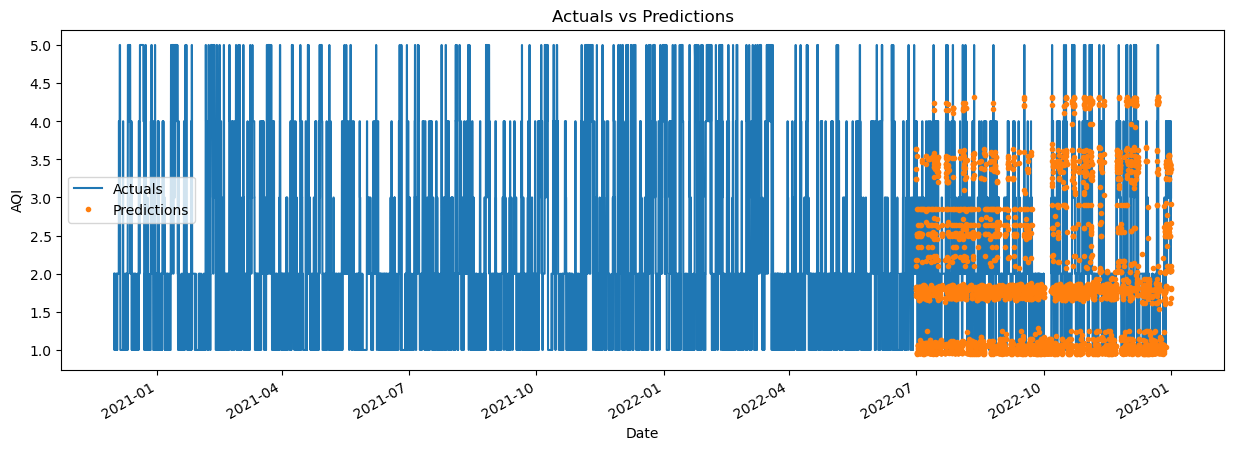

In [29]:
ax = df[['aqi']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Actuals','Predictions'])
ax.set_title('Actuals vs Predictions')
plt.ylabel('AQI')
plt.xlabel('Date')
plt.show()

15. Calculate the Root Mean Squared Error and the Mean Squared Error. As you can see, it is very low since the values the model is predicting are very close together (the AQI this data uses ranges only from 1 to 5). 

In [30]:
rmse = np.sqrt(mean_squared_error(test['aqi'],test['prediction']))
rmse 

0.5055555182133733

In [31]:
mse = mean_squared_error(test['aqi'],test['prediction'])
mse

0.25558638199599243

16. Score the model for the training data, the number you get back is the coefficient of determination. The result was .82, which is relatively close to 1, so the model did a good job of predicting values. But, it did not do as well as when the model predicted PM2.5 values. 

In [32]:
trainScore = reg.score(X_train, y_train)
trainScore

0.8274307022769549

17. Score the model for the testing data. The result was .79, so the model did not do as well on the testing data when compared to the training data, but the result is still relatively close to 1.

In [33]:
testScore = reg.score(X_test, y_test)
testScore

0.7948087464185737

18. Save the model. 

In [34]:
from joblib import dump, load 

In [35]:
dump (reg, 'XGB_aqi.model')

['XGB_aqi.model']